<a href="https://colab.research.google.com/github/Pehlevan-Group/dmft_wide_networks/blob/main/two_layer_nonlinear_DMFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax import random
import seaborn as sns
from jax.example_libraries import optimizers
from jax import grad, vmap, jacfwd
import sys

In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [3]:

def get_phi_kernel(H):
    sqrt_diag = jnp.sqrt(jnp.diag(H)+5e-7)
    cosTheta = H / jnp.outer(sqrt_diag, sqrt_diag) 
    Phi = 1/(2*jnp.pi) * jnp.outer(sqrt_diag, sqrt_diag)*( jnp.sqrt(1-cosTheta**2) + (jnp.pi - jnp.arccos(cosTheta))*cosTheta ) 
    return Phi

# < phi'(x) phi'(z) > 
def get_dot_phi(H):
    sqrt_diag = jnp.sqrt(jnp.diag(H)+5e-7)
    cosTheta = H / jnp.outer(sqrt_diag, sqrt_diag) 
    Phi = 1/(2*jnp.pi) * ( jnp.pi - jnp.arccos(cosTheta) )
    return Phi

def initialize_kernels(Kx, depth, T):
    H = Kx * 1.0
    all_Phi = []
    for l in range(depth):
        Phi = get_phi_kernel(H)
        all_Phi += [Phi]
        H = Phi * 1.0
    
    all_G = [get_dot_phi(all_Phi[-1])]
    for l in range(depth-1):
        all_G.insert(0,  all_G[0] * get_dot_phi(all_Phi[-2-l]) )
    
    all_Phi_tp = []
    all_G_tp = []
    
    for l, Phil in enumerate(all_Phi):
        Gl = all_G[l]
        Phitp = np.zeros((T,P,T,P))
        Gtp = np.zeros((T,P,T,P))
        for t in range(T):
            for s in range(T):
                Phitp[t,:,s,:] = Phil
                Gtp[t,:,s,:] = Gl
        all_Phi_tp += [Phitp]
        all_G_tp += [Gtp]
    
    H0 = np.zeros((T,P,T,P))
    for t in range(T):
        for s in range(T):
            H0[t,:,s,:] = Kx
    
    return all_Phi_tp, all_G_tp, H0

def solve_Delta(Kx, y, all_Phi, all_G, eta):
    T = all_Phi[0].shape[0]
    P = all_Phi[0].shape[1]
    Delta = np.zeros((T,P))
    Delta[0,:] = y*1.0
    NTK = jnp.einsum('ijil,jl->ijl', all_G[0], Kx)
    depth = len(all_Phi)
    for l in range(depth-1):
        NTK += jnp.einsum('ijil,ijil->ijl', all_G[l+1], all_Phi[l])
    NTK += jnp.einsum('ijil->ijl', all_Phi[depth-1])
    
    for t in range(T-1):
        Delta[t+1,:] = Delta[t,:] - eta / P * NTK[t,:,:] @ Delta[t,:]    
    return Delta

def solve_self_consistent(Phi_minus, G_plus, Delta, chi, xi, eta_gam, num_step = 2500):
    
    h = chi * 1.0
    z = xi * 1.0
    P = Phi_minus.shape[1]
    
    Phi_tril = jnp.tril( Phi_minus.transpose((1,3,0,2)) , k=-1).transpose((2,0,3,1))
    G_tril = jnp.tril( G_plus.transpose((1,3,0,2)) , k=-1).transpose((2,0,3,1))
    for n in range(num_step):
        
        
        phi = h * (h > 0.0)
        g = z * (h>0.0)
        
        # g is samples x T x P Delta is T x P
        g_Delta = jnp.einsum('ijk,jk->ijk', g, Delta)
        phi_Delta = jnp.einsum('ijk,jk-> ijk', phi, Delta)
        
        dh = eta_gam / P * jnp.einsum('ijk,nmjk->inm', g_Delta,  Phi_tril)
        dz = eta_gam / P * jnp.einsum('ijk,nmjk->inm', phi_Delta, G_tril)
        
        
        h_new = 1.0*chi + dh
        z_new = 1.0*xi  + dz
        
        loss = ( jnp.sum((h_new-h)**2) + jnp.sum((z_new-z)**2) ) / (jnp.sum(h**2) + jnp.sum(z**2) )
        h = h_new 
        z = z_new
        if loss < 1e-10:
            break        
    return h, z



def solve_self_consistent_four_vars(Phi_minus, G_plus, A, B, Delta, t, r, nonlin_fn, dnonlin_fn, eta_gam, num_step = 500):
    h = t * 1.0
    z = r * 1.0
    P = Phi_minus.shape[1]
    
    causal_tt = jnp.tril( jnp.ones((T,T)), k=-1 )
    Phi_tril = jnp.einsum('ijkl,ik->ijkl', Phi_minus, causal_tt)
    C = eta_gam / P * jnp.einsum('ijkl,kl->ijkl', Phi_tril, Delta) 
    
    G_tril = jnp.einsum('ijkl,ik->ijkl', G_plus, causal_tt)
    D = eta_gam / P * jnp.einsum('ijkl,kl->ijkl', G_tril, Delta) 
    for n in range(num_step):
        
        phi = nonlin_fn(h)
        g = z * dnonlin_fn(h)
        
        chi = t + jnp.einsum('ijk,mnjk->imn', g, A) # chi = t + A g
        xi = r + jnp.einsum('ijk,mnjk->imn', phi, B) # xi = r + B^T phi
        
        
        h_new = chi + jnp.einsum('ijk,mnjk->imn', g, C)
        z_new = xi + jnp.einsum('ijk,mnjk->imn', phi, D)
        
        loss = ( jnp.sum((h_new-h)**2) + jnp.sum((z_new-z)**2) ) / (jnp.sum(h**2) + jnp.sum(z**2) )
        h = h_new 
        z = z_new
        if loss < 1e-6:
            break        
    return h, z, chi,xi

# computes Jacobians  dh/du, dh/dr, dz/du, dz/dr
# takes in h, z which solve fixed point equations above 
# and calculates < dphi / dr > and < dg / du > for A, B 
def solve_jacobians_batched(Phi_minus, G_plus, A, B, Delta, h, z, nonlin_fn, dnonlin_fn, eta_gam, num_step = 40):
    P = Phi_minus.shape[1]
    causal_tt = jnp.tril( jnp.ones((T,T)), k=-1 )
    Phi_tril = jnp.einsum('ijkl,ik->ijkl', Phi_minus, causal_tt)
    C = eta_gam / P * jnp.einsum('ijkl,kl->ijkl', Phi_tril, Delta) + A 
    
    G_tril = jnp.einsum('ijkl,ik->ijkl', G_plus, causal_tt)
    D = eta_gam / P * jnp.einsum('ijkl,kl->ijkl', G_tril, Delta) + B
    
    batch_size = 100
    num_batches = int(h.shape[0] / batch_size)
    dphi_dr_avg = jnp.zeros((T,P,T,P))
    dg_du_avg = jnp.zeros((T,P,T,P))
    
    for batch_n in range(num_batches):
        sys.stdout.write('\r batch = %d' % batch_n)
        hb = h[batch_n*batch_size:(batch_n+1)*batch_size]
        zb = h[batch_n*batch_size:(batch_n+1)*batch_size]
        id_batch = jnp.einsum('i,jklm->ijklm', jnp.ones(batch_size), jnp.einsum('ik,jl->ijkl', jnp.eye(T), jnp.eye(P)))
        dh_du = id_batch
        dz_dr = id_batch
        dh_dr = jnp.zeros((batch_size, T,P,T,P))
        dz_du = jnp.zeros((batch_size, T,P,T,P))
        dot_phi_b = dnonlin_fn(hb)
        phi_b = nonlin_fn(h)
        for n in range(num_step):
            
            
            # dg/du = dphi(h) * dz/du, 
            dg_du = jnp.einsum('ijk,ijklm->ijklm', dot_phi_b, dz_du)
            dg_dr = jnp.einsum('ijk,ijklm->ijklm', dot_phi_b, dz_dr)
            
            # dh/du = I + C dg_du , dh/dr = C dg/dr
            dh_du = id_batch + jnp.einsum('jklm, ilmno->ijkno', C, dg_du)
            dh_dr = jnp.einsum('jklm, ilmno->ijkno', C, dg_dr)
            
            # dphi/du, dphi/dr
            dphi_du = jnp.einsum('ijk,ijklm->ijklm', dot_phi_b, dh_du)
            dphi_dr = jnp.einsum('ijk,ijklm->ijklm', dot_phi_b, dz_du)
            
            # dz/dr = I + D dphi/dr ,  dz/du = D dphi/du
            dz_dr = id_batch + jnp.einsum('jklm, ilmno->ijkno', D, dphi_dr)
            dz_du = jnp.einsum('jklm, ilmno->ijkno', D, dphi_du)
            
        
        dphi_dr_avg += 1/num_batches * jnp.mean(dphi_dr, axis = 0)
        dg_du_avg += 1/num_batches * jnp.mean(dg_du_avg, axis = 0)
    
    return dphi_dr_avg, dg_du_avg



def DMFT_Theory(Kx, y, depth=3, T=100, eta = 0.01, gamma=1.0, num_iter=12, samples = 1000, alpha = 0.6):
    P = Kx.shape[0]
    # initialize kernels
    all_Phi, all_G, H0 = initialize_kernels(Kx, depth, T)
    Delta0 = solve_Delta(Kx, y, all_Phi, all_G, eta)
    key = random.PRNGKey(0)
    for n in range(num_iter):
        
        new_Phi = []
        new_G = []
        Delta = solve_Delta(Kx, y, all_Phi, all_G, eta)
        #plt.plot(jnp.mean(Delta**2 ,axis = 1))
        #plt.plot(jnp.mean(Delta0**2,axis = 1), '--',color = 'black')
        #plt.show()
        for l in range(depth):
            if l == 0:
                Phi_minus = H0
                S, V = jnp.linalg.eigh(Kx+1e-8)
                S = S * (S > 0.0)
                Z = random.normal(key, (samples, P))
                key, _ = random.split(key)
                chi_1 = V @ jnp.diag( S**(0.5) ) @ Z.T # P x samples
                chi = jnp.einsum('ij,k->jki', chi_1, jnp.ones(T)) # samples x T x P
                #print(chi[0,0:5,0:5])
            else:
                Phi_minus = all_Phi[l-1]
                Phi_sqr = Phi_minus.reshape((T*P,T*P))
                S, V = jnp.linalg.eigh(Phi_sqr+1e-12)
                S = S*(S>0.0)
                Z = random.normal(key, (samples, T*P))
                key,_=random.split(key)
                chi_0 = V @ jnp.diag(S**(0.5)) @ Z.T
                chi_0 = chi_0.T # samples x P*T
                chi = chi_0.reshape((samples, T, P))
                #for i in range(5):
                #    plt.plot(chi[0,:,i])
                #plt.show()
                
            if l == depth -1:
                G_plus = jnp.ones((T,P,T,P))
                xi_0 = random.normal(key, (samples,))
                xi = jnp.einsum('i,jk->ijk', xi_0, jnp.ones((T,P)))
                #print(xi[0,0:5,0:5])
            else:
                G_plus = all_G[l+1]
                G_sqr = G_plus.reshape((T*P,T*P))
                S, V = jnp.linalg.eigh(G_sqr+1e-12)
                S = S*(S>0.0) 
                Z = random.normal(key, (samples, P*T))
                key,_ = random.split(key)
                xi_0 = V @ jnp.diag(S**(0.5)) @ Z.T
                xi_0 = xi_0.T
                xi = xi_0.reshape((samples, T, P))
                #for i in range(5):
                #    plt.plot(xi[0,:,i])
                #plt.show()
            
            h, z = solve_self_consistent(Phi_minus, G_plus, Delta, chi, xi, eta_gam = eta*gamma)
            phi = h * (h > 0.0)
            g = z * (h > 0.0)
            
            
            new_Phi += [ 1/samples * jnp.einsum('ijk,ilm->jklm', phi, phi) ]
            new_G += [ 1/samples * jnp.einsum('ijk,ilm->jklm', g, g) ]
            #all_Phi[l] = alpha*new_Phi[l] + (1-alpha) * all_Phi[l]
            # sample chi, xi
            # solve h g
            # update kernel definition
        
        all_Phi = [alpha*new_Phi[l] + (1-alpha) * all_Phi[l] for l in range(depth)]
        all_G  = [alpha*new_G[l] + (1-alpha) * all_G[l] for l in range(depth)]
        
        #print("last phi norm")
        #print( jnp.mean( all_Phi[-1]**2 ) )
        
    return all_Phi, all_G




def solve_self_consistent_jax(Phi_minus, G_plus, Delta, chi, xi, eta_gam, num_step = 2500):
    
    h = chi * 1.0
    z = xi * 1.0
    P = Phi_minus.shape[1]
    causal_tt = jnp.tril( jnp.ones((T,T)), k=-1 )
    #Phi_tril_fn = lambda Phi: jnp.einsum('ijkl,ik->ijkl', Phi, causal_tt)
    #G_tril_fn = lambda G: jnp.einsum('ijkl,ik->ijkl', G, causal_tt)
    Phi_tril = jnp.einsum('ijkl,ik->ijkl', Phi_minus, causal_tt)
    G_tril = jnp.einsum('ijkl,ik->ijkl', G_plus, causal_tt)
    #Phi_tril = jnp.tril( Phi_minus.transpose((1,3,0,2)) , k=-1).transpose((2,0,3,1))
    #G_tril = jnp.tril( G_plus.transpose((1,3,0,2)) , k=-1).transpose((2,0,3,1))
    
    phi_fn = lambda h: h * (h>0.0)
    g_fn = lambda h,z: z * (h>0.0)
    g_Delta_fn = lambda h,z: jnp.einsum('jk,jk->jk', g_fn(h,z), Delta)
    phi_Delta_fn = lambda h: jnp.einsum('jk,jk->jk', phi_fn(h), Delta) 
    # non-vmapped versions
    fh = lambda h, z: eta_gam / P * jnp.einsum('jk,nmjk->nm', g_Delta_fn(h,z),  Phi_tril) 
    fz = lambda h: eta_gam / P * jnp.einsum('jk,nmjk->nm', phi_Delta_fn(h), G_tril) 
    
    print("test")
    vmap_fz = vmap(fz, (0), 0)
    vmap_fh = vmap(fh, (0,0),0)
    print(vmap_fz(h).shape)
    for n in range(num_step):
        
        dh, dz = vmap_fh(h,z), vmap_fz(h)
        h_new = dh + chi
        z_new = dz + xi
        loss = ( jnp.sum((h_new-h)**2) + jnp.sum((z_new-z)**2) ) / (jnp.sum(h**2) + jnp.sum(z**2) )
        h = h_new 
        z = z_new
        if loss < 1e-10:
            break
    print("getting jacobians all sample")
    J1_fn = vmap( lambda h,z: jacfwd(fh)(h,z), (0,0), 0)
    J2_fn = vmap( lambda h: jacfwd(fz)(h), (0),0)
    print(J1_fn(h[0:15,:,:], z[0:15,:,:]).shape)
    print(J2_fn(h[0:15,:,:]).shape)
    return h, z, fh, fz

# implicit function theorem
def DMFT_Autograd(Kx, y, depth=3, T=100, eta = 0.01, gamma=1.0, num_iter=12, samples = 1000, alpha = 0.6):
    P = Kx.shape[0]
    # initialize kernels
    all_Phi, all_G, H0 = initialize_kernels(Kx, depth, T)
    print(len(all_Phi))
    print(len(all_G))
    print(all_Phi[0].shape)
    print(all_G[0].shape)
    Delta0 = solve_Delta(Kx, y, all_Phi, all_G, eta)
    key = random.PRNGKey(0)
    for n in range(num_iter):
        
        new_Phi = []
        new_G = []
        Delta = solve_Delta(Kx, y, all_Phi, all_G, eta)
        plt.plot(jnp.mean(Delta**2 ,axis = 1))
        plt.plot(jnp.mean(Delta0**2,axis = 1), '--',color = 'black')
        plt.show()
        for l in range(depth):
            if l == 0:
                Phi_minus = H0
                S, V = jnp.linalg.eigh(Kx+1e-12)
                S = S * (S > 0.0)
                Z = random.normal(key, (samples, P))
                key, _ = random.split(key)
                chi_1 = V @ jnp.diag( S**(0.5) ) @ Z.T # P x samples
                chi = jnp.einsum('ij,k->jki', chi_1, jnp.ones(T)) # samples x T x P
                #print(chi[0,0:5,0:5])
            else:
                Phi_minus = all_Phi[l-1]
                Phi_sqr = Phi_minus.reshape((T*P,T*P))
                S, V = jnp.linalg.eigh(Phi_sqr+1e-12)
                S = S*(S>0.0)
                Z = random.normal(key, (samples, T*P))
                key,_=random.split(key)
                chi_0 = V @ jnp.diag(S**(0.5)) @ Z.T
                chi_0 = chi_0.T # samples x P*T
                chi = chi_0.reshape((samples, T, P))
                #for i in range(5):
                #    plt.plot(chi[0,:,i])
                #plt.show()
                
            if l == depth -1:
                G_plus = jnp.ones((T,P,T,P))
                xi_0 = random.normal(key, (samples,))
                xi = jnp.einsum('i,jk->ijk', xi_0, jnp.ones((T,P)))
                #print(xi[0,0:5,0:5])
            else:
                G_plus = all_G[l+1]
                G_sqr = G_plus.reshape((T*P,T*P))
                S, V = jnp.linalg.eigh(G_sqr+1e-12)
                S = S*(S>0.0) 
                Z = random.normal(key, (samples, P*T))
                key,_ = random.split(key)
                xi_0 = V @ jnp.diag(S**(0.5)) @ Z.T
                xi_0 = xi_0.T
                xi = xi_0.reshape((samples, T, P))
                #for i in range(5):
                #    plt.plot(xi[0,:,i])
                #plt.show()
            
            h, z, fh, fz = solve_self_consistent_jax(Phi_minus, G_plus, Delta, chi, xi, eta_gam = eta*gamma)
            phi = h * (h > 0.0)
            g = z * (h > 0.0)
            
            new_Phi += [ 1/samples * jnp.einsum('ijk,ilm->jklm', phi, phi) ]
            new_G += [ 1/samples * jnp.einsum('ijk,ilm->jklm', g, g) ]
            #all_Phi[l] = alpha*new_Phi[l] + (1-alpha) * all_Phi[l]
            # sample chi, xi
            # solve h g
            # update kernel definition
        
        all_Phi = [alpha*new_Phi[l] + (1-alpha) * all_Phi[l] for l in range(depth)]
        all_G  = [alpha*new_G[l] + (1-alpha) * all_G[l] for l in range(depth)]
        
        print("last phi norm")
        print( jnp.mean( all_Phi[-1]**2 ) )
        
    return all_Phi, all_G

# need MCMC for layer 1, layers 1< l < L and layer L
# for layer 1, chi does not need to be resampled. For layer L, xi does not need to be resample

def DMFT_Theory_Cross_Term(Kx, y, depth=3, T=100, eta = 0.01, gamma=1.0, num_iter=16, samples = 1000, alpha = 0.8, nonlin = 'relu', beta = 1.0):
    P = Kx.shape[0]
    # initialize kernels
    all_Phi, all_G, H0 = initialize_kernels(Kx, depth, T)
    print(len(all_Phi))
    print(len(all_G))
    print(all_Phi[0].shape)
    print(all_G[0].shape)
    all_A = [jnp.zeros((T,P,T,P)) for l in range(depth)]
    all_B = [jnp.zeros((T,P,T,P)) for l in range(depth)]
    Delta0 = solve_Delta(Kx, y, all_Phi, all_G, eta)
    key = random.PRNGKey(0)
    if nonlin == 'tanh':
        nonlin_fn = lambda h: jnp.tanh(h * beta) / beta
        dnonlin_fn = lambda h: 1.0 - jnp.tanh(h * beta)**2
    else:
        nonlin_fn = lambda h: (h>0.0) * h
        dnonlin_fn = lambda h: 1.0 * (h>0.0)
    
    for n in range(num_iter):
        
        new_Phi = []
        new_G = []
        new_A = [jnp.zeros((T,P,T,P)) for l in range(depth-1)]
        new_B = [jnp.zeros((T,P,T,P)) for l in range(depth-1)]
        new_V1 = []
        new_V2 = []
        Delta = solve_Delta(Kx, y, all_Phi, all_G, eta)
        plt.plot(jnp.mean(Delta**2 ,axis = 1))
        plt.plot(jnp.mean(Delta0**2,axis = 1), '--', color = 'black')
        plt.show()
        
        for l in range(depth):
            
            if l == 0:
                A_minus = jnp.zeros((T,P,T,P))
            else:
                A_minus = all_A[l-1]
            
            if l == depth-1:
                Bl = jnp.zeros((T,P,T,P))
            else:
                Bl = all_B[l]
                
            if l == 0:
                Phi_minus = H0
                S, V = jnp.linalg.eigh(Kx+1e-6)
                S = S * (S > 0.0)
                S = S+1e-6
                Z = random.normal(key, (samples, P))
                key, _ = random.split(key)
                chi_1 = V @ jnp.diag( S**(0.5) ) @ Z.T # P x samples
                t = jnp.einsum('ij,k->jki', chi_1, jnp.ones(T))  # samples x T x P
                Phi_minus_inv = jnp.linalg.inv(Phi_minus.reshape((T*P,T*P)) + 1e-5*jnp.eye(T*P) ).reshape((T,P,T,P))

            else:
                Phi_minus = all_Phi[l-1]
                Phi_sqr = Phi_minus.reshape((T*P,T*P))
                S, V = jnp.linalg.eigh(Phi_sqr+1e-6)
                S = S*(S>0.0)
                S = S + 1e-5
                Z = random.normal(key, (samples, T*P))
                key,_= random.split(key)
                chi_0 = V @ jnp.diag(S**(0.5)) @ Z.T
                chi_0 = chi_0.T # samples x P*T
                t = chi_0.reshape((samples, T, P))
                Phi_minus_inv = V @ jnp.diag(S**(-1.0)) @ V.T
                Phi_minus_inv = Phi_minus_inv.reshape((T,P,T,P))
                
            if l == depth - 1:
                G_plus = jnp.ones((T,P,T,P))
                xi_0 = random.normal(key, (samples,))
                r = jnp.einsum('i,jk->ijk', xi_0, jnp.ones((T,P)))
                G_inv = jnp.linalg.inv(G_plus.reshape((T*P,T*P)) + 1e-5*jnp.eye(T*P)).reshape((T,P,T,P))
                #print(xi[0,0:5,0:5])
            else:
                G_plus = all_G[l+1]
                G_sqr = G_plus.reshape((T*P,T*P))
                S, V = jnp.linalg.eigh(G_sqr+1e-6)
                S = S*(S>0.0)
                S = S + 1e-5
                Z = random.normal(key, (samples, P*T))
                key,_ = random.split(key)
                xi_0 = V @ jnp.diag(S**(0.5)) @ Z.T
                xi_0 = xi_0.T
                #xi = xi_0.reshape((samples, T, P)) + jnp.einsum('i,jk->ijk', jnp.ones(samples), jnp.einsum('ijkl,ij->kl', Bl, all_phi_mean[l]))
                r = xi_0.reshape((samples, T, P))
                G_inv = V @ jnp.diag(S**(-1.0)) @ V.T
                G_inv = G_inv.reshape((T,P,T,P))
            
            print("solving for h, z")
            h, z, chi, xi = solve_self_consistent_four_vars(Phi_minus, G_plus, A_minus, Bl, Delta, t, r, nonlin_fn, dnonlin_fn, eta_gam = eta*gamma)
            
            #h, z, chi, xi = solve_self_consistent_four_vars(Phi_minus, G_plus, jnp.zeros((T,P,T,P)), jnp.zeros((T,P,T,P)), Delta, t, r, nonlin_fn, dnonlin_fn, eta_gam = eta*gamma)
            print("h g power")
            print(jnp.mean(h**2))
            print(jnp.mean(z**2))
            phi = nonlin_fn(h)
            g = z * dnonlin_fn(h)                        
            # < phi r >
            # compute A = < phi xi> G^{-1} and B = 1/2 Phi^{-1} <phi xi>
            #phi_r_corr = 1/samples * jnp.einsum('ijk,ilm->jklm', phi, r)
            #A_new = jnp.einsum('ijkl,klmn->ijmn', phi_r_corr, G_inv)
            #new_A[l] = jnp.einsum('ijkl,klmn->ijmn', phi_r_corr, G_inv)
            
            # < t g > = < (chi - Ag) g> = <xi phi> - A G;
            # B^T = < g u^T > Phi^{-1}
            #g_t_corr = 1/samples * jnp.einsum('ijk,ilm->jklm', g , t)
            #B_minus_new = jnp.einsum('ijkl,klmn->ijmn', g_t_corr, Phi_minus_inv) # actually B.T 
            #B_minus_new = jnp.einsum('ijkl,klmn->ijmn', Phi_minus_inv, phi_xi_r)
            #new_B[l] = jnp.einsum('ijkl,klmn->ijmn', Phi_minus_inv, phi_xi_r)
            
            # two correlators which should in principle be identical
            #V1 = 1/samples * jnp.einsum('ijk,ilm->jklm', phi, xi) 
            #V2 = 1/samples * jnp.einsum('ijk,ilm->jklm', chi, g)
            
            #new_V1 += [ V1 ]
            #new_V2 += [ V2 ]
            
            # A G = <phi r> = <phi xi> - Phi B = < chi^{l+1} g^{\ell+1} > - Phi B
            # Phi B = < u g> = < chi g > - A G = < phi xi > - AG
            #Al_G = V2 - 
            
            # solve for jacobians
            A_new, B_minus_new = solve_jacobians_batched(Phi_minus, G_plus, A_minus, Bl, Delta, h, z, nonlin_fn, dnonlin_fn, eta_gam=eta*gamma)
            #A_new= jnp.zeros((T,P,T,P))
            #B_minus_new = jnp.zeros((T,P,T,P))
            
            new_Phi += [ 1/samples * jnp.einsum('ijk,ilm->jklm', phi, phi) ]
            new_G += [ 1/samples * jnp.einsum('ijk,ilm->jklm', g, g) ] 
            
            if l < depth-1:
                new_A += [A_new]
                #new_A += [jnp.zeros((T,P,T,P))]
                print("new A")
                print(jnp.mean(A_new**2))
            if l > 0:
                new_B += [B_minus_new]
                #new_B += [jnp.zeros((T,P,T,P))]
                print("new B")
                print(jnp.mean(B_minus_new**2))
                
            print("new Phi")
            print(jnp.mean(new_Phi[-1]**2))
            print("new G")
            print(jnp.mean(new_G[-1]**2))                
        
        print("Vl errors")
        for l, V1l in enumerate(new_V1):
            print(jnp.mean((V1l - new_V2[l])**2))
        
        # calculate A, B in two ways using the different layers...
        # A_l = < phi_l r_l > G_{l+1}^{-1} = < phi_l xi_l> G_{l+1}^{-1} - <phi_l phi_l> B_l 
        #     = < chi_{l+1} g_{l+1} > G_{l+1}^{-1} - Phi_l B_l
        # B_{l}^T = < g_{l+1} u_{l+1} > Phi_{l}^{-1} = < g chi > Phi^{-1} - < g g > 
        
        all_Phi = [alpha*new_Phi[l] + (1-alpha) * all_Phi[l] for l in range(depth)]
        all_G  = [alpha*new_G[l] + (1-alpha) * all_G[l] for l in range(depth)]
        alpha_AB = alpha * 0.2
        all_A = [alpha_AB* all_A[l] + (1-alpha_AB) * A for l, A in enumerate(new_A)]
        all_B = [alpha_AB * all_B[l] + (1-alpha_AB)* B for l,B in enumerate(new_B)] 

        print("last phi norm")
        print( jnp.mean( all_Phi[-1]**2 ) ) 
        
    return all_Phi, all_G, all_A, all_B


def sample_chi_h_xi_z(all_Phi, all_G, Kx, samples = 2000):
    
    all_h = []
    all_z = []
    all_chi = []
    all_xi = []
    _, _, H0 = initialize_kernels(Kx, len(all_Phi), all_Phi[0].shape[0])
    key = random.PRNGKey(0)

    for l in range(depth):
            if l == 0:
                Phi_minus = H0
                S, V = jnp.linalg.eigh(Kx+1e-12)
                S = S * (S > 0.0)
                Z = random.normal(key, (samples, P))
                key, _ = random.split(key)
                chi_1 = V @ jnp.diag( S**(0.5) ) @ Z.T # P x samples
                chi = jnp.einsum('ij,k->jki', chi_1, jnp.ones(T)) # samples x T x P
                #print(chi[0,0:5,0:5])
            else:
                Phi_minus = all_Phi[l-1]
                Phi_sqr = Phi_minus.reshape((T*P,T*P))
                S, V = jnp.linalg.eigh(Phi_sqr+1e-12)
                S = S*(S>0.0)
                Z = random.normal(key, (samples, T*P))
                key,_=random.split(key)
                chi_0 = V @ jnp.diag(S**(0.5)) @ Z.T
                chi_0 = chi_0.T # samples x P*T
                chi = chi_0.reshape((samples, T, P))
                #for i in range(5):
                #    plt.plot(chi[0,:,i])
                #plt.show()
                
            if l == depth - 1:
                G_plus = jnp.ones((T,P,T,P))
                xi_0 = random.normal(key, (samples,))
                xi = jnp.einsum('i,jk->ijk', xi_0, jnp.ones((T,P)))
                #print(xi[0,0:5,0:5])
            else:
                G_plus = all_G[l+1]
                G_sqr = G_plus.reshape((T*P,T*P))
                S, V = jnp.linalg.eigh(G_sqr+1e-12)
                S = S* ( S>0.0 ) 
                Z = random.normal(key, (samples, P*T))
                key,_ = random.split(key)
                xi_0 = V @ jnp.diag(S**(0.5)) @ Z.T
                xi_0 = xi_0.T
                xi = xi_0.reshape((samples, T, P))
                #for i in range(5):
                #    plt.plot(xi[0,:,i])
                #plt.show()
            
            h, z = solve_self_consistent(Phi_minus, G_plus, Delta, chi, xi, eta_gam = eta*gamma)
            all_chi += [chi]
            all_xi += [xi]
            all_h += [h]
            all_z += [z]
    return all_chi, all_h, all_xi, all_z



[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1.]


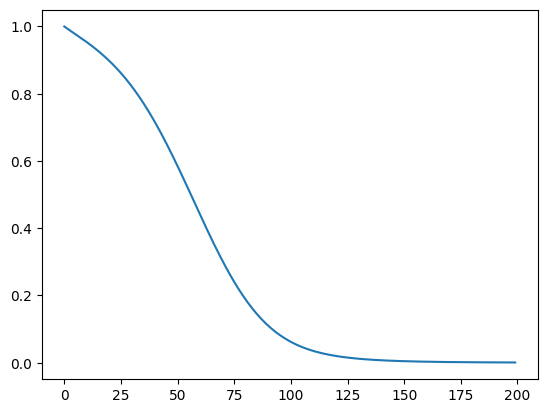

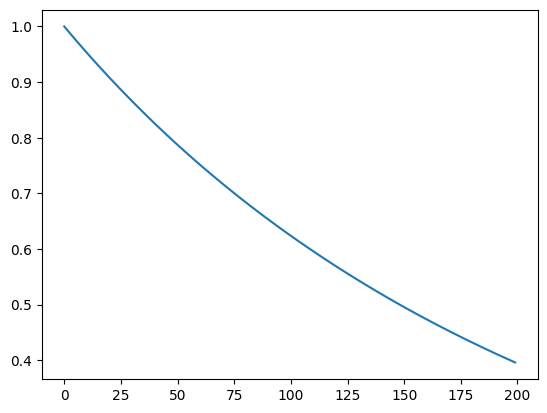

In [4]:
depth = 1 # number of hidden N neuron layers
eta = 0.075
T = 200
P = 25
D = 40
key = random.PRNGKey(0)
X = random.normal(key,(D,P)) 
Kx = X.T @ X / D

y = -1.0*np.ones(P)
y[0:P//2]= np.ones(P//2)

Kx = jnp.array(Kx)
y = jnp.array(y)
print(y)

gamma = 3.0
beta = 0.25

gamma_vals = []

all_Phi, all_G = DMFT_Theory(Kx, y, depth=depth, eta=eta, T=T, gamma = gamma, samples = 1000)
#all_Phi, all_G  = DMFT_Autograd(Kx, y, depth=depth, eta=eta, T=T, gamma = gamma, samples = 2500)
Delta = solve_Delta(Kx, y, all_Phi, all_G, eta)
plt.plot(jnp.mean(Delta**2, axis = 1))
plt.show()

all_Phi_lazy, all_G_lazy = DMFT_Theory(Kx, y, depth=depth, eta=eta, T=T, gamma = 0.05*gamma, samples = 1000, num_iter= 4)
Delta_lazy = solve_Delta(Kx, y, all_Phi_lazy, all_G_lazy, eta)
plt.plot(jnp.mean(Delta_lazy**2, axis = 1))
plt.show()

In [8]:
def construct_NN(depth, N, D, key):
    params = [random.normal(key, (N, D))]
    for l in range(depth -1):
        key,_ = random.split(key)
        params += [random.normal(key, (N,N))]
    params += [random.normal(key, (N,))]
    return params

def nonlin_tanh(h, beta=1.0):
    return jnp.tanh(beta*h)/beta

def nonlin_dtanh(h,beta=1.0):
    return 1.0 - jnp.tanh(beta*h)**(2)


def NN_func(params, X, y, gamma, nonlin_fn):
    h = params[0] @ X / jnp.sqrt(X.shape[0])
    L = len(params)-1
    N = params[0].shape[0]
    
    for l in range(L-1):
        
        phi = nonlin_fn(h)
        h = params[l+1] @ phi / jnp.sqrt(N)
    phi = nonlin_fn(h)
    return phi.T @ params[L] / ( N * gamma)

def NN_train(X, y, depth, N, eta, gamma, nonlin='relu', beta = 1.0):
    params= construct_NN(depth, N, D = X.shape[0], key= random.PRNGKey(0))
    opt_init, opt_update, get_params = optimizers.sgd(eta * gamma**2 * N)
    opt_state = opt_init(params)
    params0 = params
    if nonlin == 'relu':
        nonlin_fn = lambda h: (h > 0.0) * h
    else:
        nonlin_fn = lambda h: nonlin_tanh(h, beta)
    loss = lambda params: 0.5 * jnp.mean( (NN_func(params, X, y, gamma, nonlin_fn=nonlin_fn) - y )**2 )
    grad_fn = grad(loss)
    losses = []
    for t in range(T):
        losses += [2.0*loss(get_params(opt_state))]
        opt_state = opt_update(t, grad_fn(get_params(opt_state)), opt_state)
    return losses, get_params(opt_state), params0

def get_features(params, params0, X, y, nonlin = 'relu'):
    all_phi = []
    all_h = []
    all_chi = []
    h = params[0] @ X / jnp.sqrt(X.shape[0])
    chi = params0[0] @ X / jnp.sqrt(X.shape[0])
    all_chi += [chi]
    all_h += [h]
    L = len(params)-1
    N = params[0].shape[0]
    if nonlin == 'relu':
        nonlin_fn = lambda h: (h>0.0)*h
    else:
        nonlin_fn = nonlin_tanh
    for l in range(L-1):
        
        phi = nonlin_fn(h)
        all_phi += [phi]
        h = params[l+1] @ phi / jnp.sqrt(N)
        all_h += [h]
        chi = params0[l+1] @ phi / jnp.sqrt(N)
        all_chi += [chi]
    phi = nonlin_fn(h)
    all_phi += [phi]
    return all_phi, all_h, all_chi

def get_features_forward_back(params, params0, X, y,nonlin = 'relu'):
    all_phi = []
    all_h = []
    all_chi = []
    h = params[0] @ X / jnp.sqrt(X.shape[0])
    chi = params0[0] @ X / jnp.sqrt(X.shape[0])
    all_chi += [chi]
    all_h += [h]
    L = len(params)-1
    N = params[0].shape[0]
    if nonlin == 'relu':
        nonlin_fn = lambda h: (h>0.0)*h
        dnonlin_fn = lambda h: 1.0 * (h>0.0)
    else:
        nonlin_fn = nonlin_tanh
        dnonlin_fn = nonlin_dtanh
        
    for l in range(L-1):
        phi = nonlin_fn(h)
        all_phi += [phi]
        h = params[l+1] @ phi / jnp.sqrt(N)
        all_h += [h]
        chi = params0[l+1] @ phi / jnp.sqrt(N)
        all_chi += [chi]
    phi = nonlin_fn(h)
    all_phi += [phi]
    
    all_z = []
    all_g = []
    all_xi = []
    z_L = jnp.outer(params[-1],jnp.ones(X.shape[1]))
    xi_L = jnp.outer(params0[-1],jnp.ones(X.shape[1]))
    #g_L = z_L * nonlin_dtanh(all_h[-1])
    #g_L = z_L * (all_h[-1] > 0.0)
    g_L = z_L * dnonlin_fn(all_h[-1])
    
    all_z += [ z_L ]
    all_xi += [ xi_L ]
    all_g += [ g_L ]
    
    for l in range(L-1):
        z_l = 1/jnp.sqrt(N) * params[-2-l].T @ all_g[0]
        
        #g_l = z_l * (all_h[-2-l] > 0.0) 
        #g_l = z_l * nonlin_dtanh(all_h[-2-l])
        g_l = z_l * nonlin_dtanh(all_h[-2-l])
        xi_l = 1/jnp.sqrt(N) * params0[-2-l].T @ all_g[0]
        all_z.insert(0, z_l)
        all_g.insert(0, g_l)
        all_xi.insert(0, xi_l)
    
    return all_phi, all_h, all_chi, all_g, all_z, all_xi


In [6]:
N = 3000
losses, params, params0 = NN_train(X, y, depth, N, eta, gamma = gamma, nonlin='relu', beta = beta)
losses0, params_lazy, params0_lazy = NN_train(X, y, depth, N, eta, gamma = 0.1*gamma, nonlin = 'relu', beta = beta)

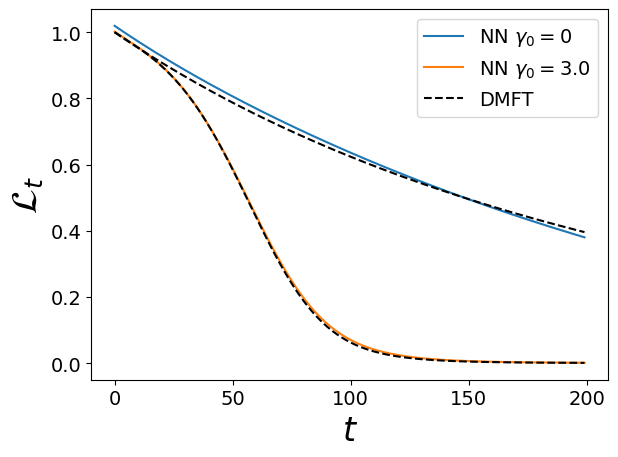

In [7]:
#plt.figure(figsize = (8,5))
plt.rcParams.update({'font.size': 14})
plt.plot(losses0, color = 'C0', label = r'NN $\gamma_0 = 0$')
plt.plot(losses, color ='C1', label = r'NN $\gamma_0 = %0.1f$' % gamma)
plt.plot(jnp.mean(Delta_lazy**2, axis = 1), '--', color = 'black', label = r'DMFT')
plt.plot(jnp.mean(Delta**2, axis = 1), '--', color = 'black')
plt.legend()
plt.xlabel(r'$t$',fontsize= 24)
plt.ylabel(r'$\mathcal{L}_t$',fontsize= 26)
#plt.ylim([0,10.1])
plt.tight_layout()
plt.show()


## Vary $\gamma_0$ in DMFT Theory

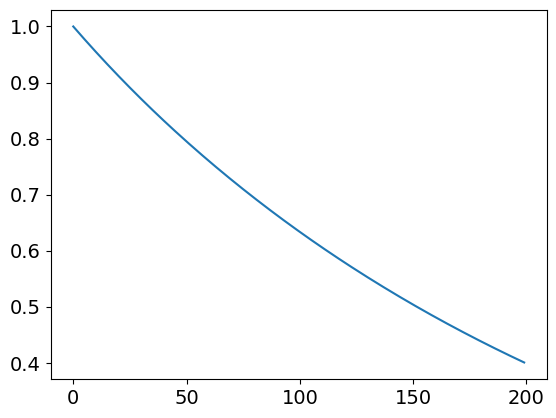

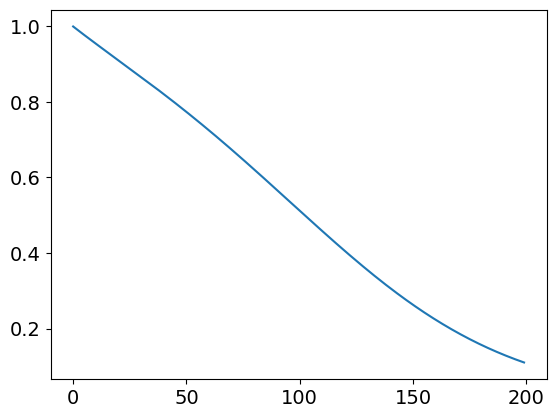

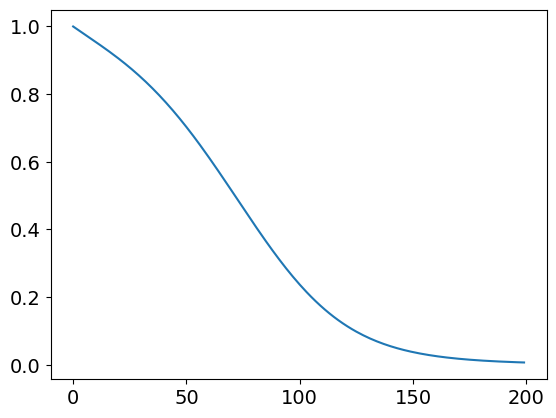

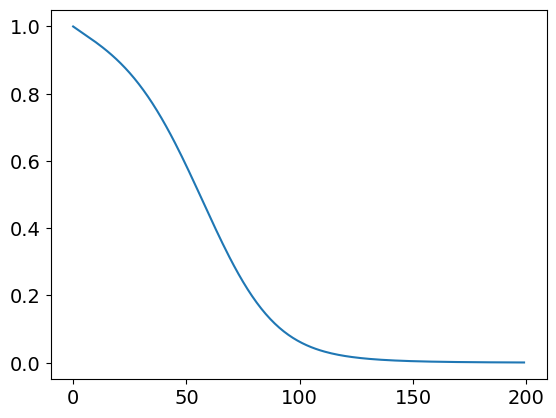

Done with DMFT


In [9]:
gamma_vals = [0.2,1.0,2.0,3.0]
all_all_Phi = []
all_all_G = []
all_Delta = []

for i,gamma in enumerate(gamma_vals):
    
    all_Phi, all_G = DMFT_Theory(Kx, y, depth=depth, eta=eta, T=T, gamma = gamma, samples = 1000)
    #all_Phi, all_G  = DMFT_Autograd(Kx, y, depth=depth, eta=eta, T=T, gamma = gamma, samples = 2500)
    Delta = solve_Delta(Kx, y, all_Phi, all_G, eta)
    plt.plot(jnp.mean(Delta**2, axis = 1))
    plt.show()
    all_all_Phi += [all_Phi[0]]
    all_all_G += [all_G[0]]
    all_Delta += [Delta]

print("Done with DMFT")


### Vary $\gamma_0$ in NN simulation

In [10]:

all_losses_expt = []
all_params = []
all_params0 = []
for i,gamma in enumerate(gamma_vals):
    losses, params, params0 = NN_train(X, y, depth, N, eta, gamma = gamma, nonlin='relu', beta = beta)
    all_losses_expt += [losses]
    all_params += [params]
    all_params0 += [params0]


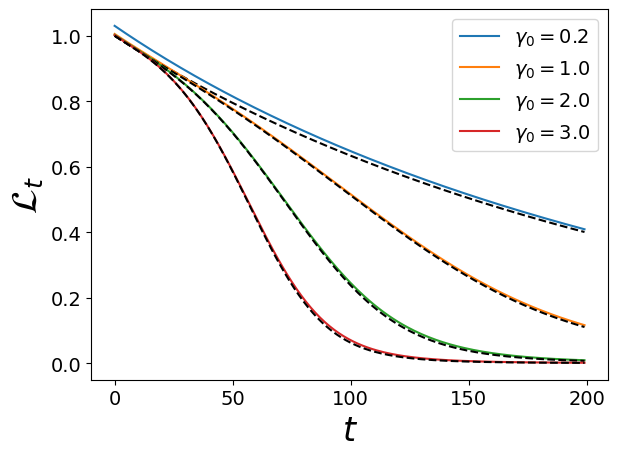

In [11]:
plt.rcParams.update({'font.size': 14})

for i, gamma in enumerate(gamma_vals):
    plt.plot(all_losses_expt[i], label = r'$\gamma_0=%0.1f$' % gamma)
    plt.plot(jnp.mean(all_Delta[i]**2, axis = 1), '--', color = 'black')
plt.legend()
plt.xlabel(r'$t$',fontsize= 24)
plt.ylabel(r'$\mathcal{L}_t$',fontsize= 26)
#plt.ylim([0,10.1])
plt.tight_layout()
plt.show()


In [12]:
all_Phi_expt = []
all_G_expt = []
all_h_expt = []
all_z_expt = []
for i, params in enumerate(all_params):
    params0 = all_params0[i]
    all_phi, all_h, all_chi, all_g, all_z, all_xi = get_features_forward_back(params, params0, X, y)
    phi = all_phi[0]
    all_Phi_expt += [1/N * phi.T @ phi]
    all_h_expt += [all_h[0]]
    g = all_g[0]
    all_G_expt += [1/N * g.T @ g]
    all_z_expt += [all_z[0]]

print("done extracting experimental kernels")

all_all_h = []
all_all_z = []
for i, gamma in enumerate(gamma_vals):
    _, all_h_th, _, all_z_th = sample_chi_h_xi_z([all_all_Phi[i]],[all_all_G[i]], Kx, samples = 3000)
    all_all_h += [all_h_th[0]]
    all_all_z += [all_z_th[0]]

done extracting experimental kernels


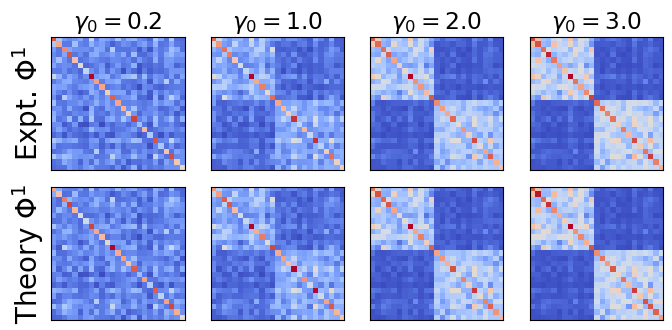

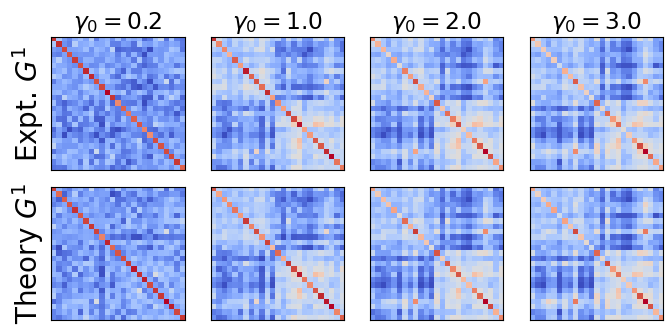

1
(3000, 200, 25)


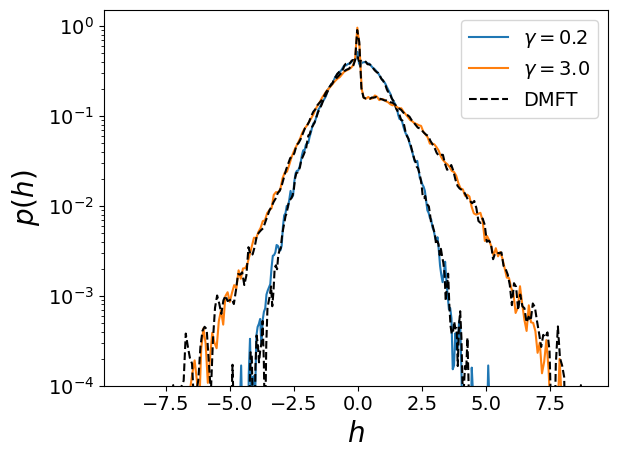

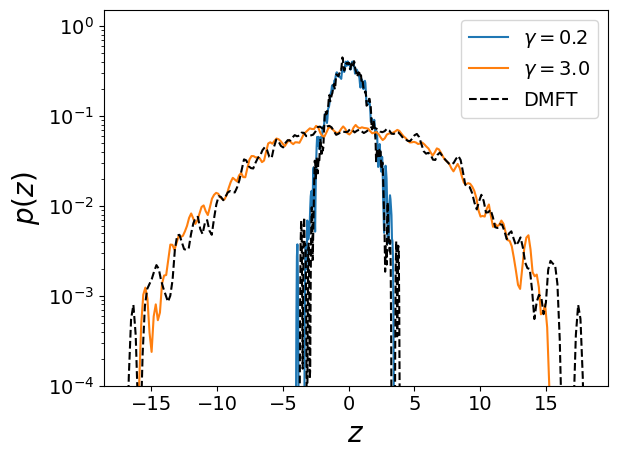

In [15]:
plt.rcParams.update({'font.size': 14})
fig_dir = 'final_theory_figs/'
plt.figure(figsize = (7,3.5))
for i, Phi in enumerate(all_all_Phi):
    plt.subplot(2,len(all_all_Phi), i+1 + len(all_all_Phi))
    plt.imshow(Phi[-1,:,-1,:], cmap = 'coolwarm')
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel(r'Theory $\Phi^1$', fontsize = 20)
    plt.subplot(2,len(all_all_Phi), i+1)
    plt.imshow(all_Phi_expt[i], cmap = 'coolwarm')
    plt.xticks([])
    plt.yticks([])
    plt.title(r'$\gamma_0 = %0.1f$' % gamma_vals[i])

    if i == 0:
        plt.ylabel(r'Expt. $\Phi^1$',fontsize = 20)
plt.tight_layout()
plt.show()

plt.figure(figsize = (7,3.5))
for i, G in enumerate(all_all_G):
    plt.subplot(2,len(all_all_Phi), i+1 + len(all_all_Phi))
    plt.imshow(G[-1,:,-1,:], cmap = 'coolwarm')
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel(r'Theory $G^1$', fontsize = 20)
    plt.subplot(2,len(all_all_Phi), i+1)
    plt.imshow(all_G_expt[i], cmap = 'coolwarm')
    plt.xticks([])
    plt.yticks([])
    plt.title(r'$\gamma_0 = %0.1f$' % gamma_vals[i])

    if i == 0:
        plt.ylabel(r'Expt. $G^1$',fontsize = 20)
plt.tight_layout()
plt.show()

print(len(all_h_th))
print(all_h_th[0].shape)
bw_param = 0.3
plt.figure()
for i, h in enumerate(all_h_expt):
    if i == 0 or i == len(all_h_expt)-1:
        sns.kdeplot(h.reshape(h.shape[0]*h.shape[1]), bw_adjust = bw_param, label = r'$\gamma = %0.1f$' % gamma_vals[i])
        if i == 0:
            sns.kdeplot(all_all_h[i][:,-1,:].reshape(all_all_h[i].shape[0]*all_all_h[i].shape[2]), linestyle = '--', color = 'black', bw_adjust = bw_param)
        else:
            sns.kdeplot(all_all_h[i][:,-1,:].reshape(all_all_h[i].shape[0]*all_all_h[i].shape[2]), linestyle = '--', label = 'DMFT', color = 'black', bw_adjust = bw_param)

plt.xlabel(r'$h$',fontsize = 20)
plt.ylabel(r'$p(h)$', fontsize = 20)
plt.yscale('log')
plt.legend()
plt.ylim([1e-4,1.5])
plt.tight_layout()
plt.show()

plt.figure()
for i, z in enumerate(all_z_expt):
    if i == 0 or i == len(all_h_expt)-1:
        sns.kdeplot(z.reshape(z.shape[0]*z.shape[1]), bw_adjust = bw_param, label = r'$\gamma = %0.1f$' % gamma_vals[i])
        if i == 0:
            sns.kdeplot(all_all_z[i][:,-1,:].reshape(all_all_z[i].shape[0]*all_all_z[i].shape[2]), linestyle = '--', color = 'black', bw_adjust = bw_param)
        else:
            sns.kdeplot(all_all_z[i][:,-1,:].reshape(all_all_z[i].shape[0]*all_all_z[i].shape[2]), linestyle = '--', label = 'DMFT', color = 'black', bw_adjust = bw_param)

plt.xlabel(r'$z$',fontsize = 20)
plt.ylabel(r'$p(z)$', fontsize = 20)
plt.yscale('log')
plt.legend()
plt.ylim([1e-4,1.5])
plt.tight_layout()
plt.show()